<p style="text-align:center"><img   src="https://portal.ups.edu.ec/o/ups-private-theme/images/ups/logo-ups-home.png"></p>
<h1 style="text-align:center"> Universidad Politécnica Salesiana </h1>
<h1 style="text-align:center"><font size="4">Práctica 1: Análisis exploratorio de datos y Extracción de Características</font></h1>

<font size="4"><span style="font-weight:bold;">Estudiante:</span> Carlos Saico</font>


## Importación de librerías

In [1]:
from time import time
from datetime import datetime, timedelta
import pandas as pd  
import numpy as np  
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA
import seaborn
from sklearn import set_config        
#Modelo secuencial quiere decir que agregaremos capas y se conectarán de manera secuencial.
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
#json:  {l1:'8',l2:'1'}
from sklearn.model_selection import train_test_split
from keras.models import load_model
print('Módulos importados')

2023-10-29 21:49:25.113393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 21:49:25.292545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 21:49:25.292577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 21:49:25.293268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 21:49:25.383966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 21:49:25.384860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Módulos importados


In [2]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

def transformarVariables(dataframe, categorical_ordinal_features, categorical_nominal_features, numeric_features, salida):
    dataframeTransformado=copy.deepcopy(dataframe)
    cantidadTotalVariables = len(dataframeTransformado.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadVariablesBinarias=cantidadVariablesBinarias+dataframeTransformado[variable].nunique()
    print('Cantidad de variables binarias: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    print('Cantidad de variables que habrá después de transformación de variables: ',cantidadTotalVariablesConTransformacion)
    #Definición de transformadores (preprocesadores)
    #1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
    categorical_ordinal_transformer = Pipeline(steps=[
        ('ordinal', OrdinalEncoder())])
    categorical_nominal_transformer_ConNombres = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida
    preprocesorCategoricoNumericoConNombres = ColumnTransformer(
        transformers=[
            ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
            ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
        ],remainder='passthrough',n_jobs=-1)
    #2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
    minmax_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler(feature_range=(0, 1)))])
    preprocesorMinMax = ColumnTransformer(transformers =[
        ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
    standardscaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True,with_std=True))])
    preprocesorStandardScaler = ColumnTransformer(transformers =[
        ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
    ], remainder ='passthrough')
    #Construcción de Pipeline con transformadores
    pipe = Pipeline(steps=[
        ('prepcn', preprocesorCategoricoNumericoConNombres), 
        #('prepstandard', preprocesorStandardScaler)
        ('prepminmax', preprocesorMinMax)
    ])
    #Transformación de variables
    X_Transformado = pipe.fit_transform(dataframeTransformado)
    print('********** Pipeline aplicado')
    guardarPipeline(pipe,'pipePreprocesadores')
    set_config(display='diagram')
    #Formación de dataframe transformado
    cnamesDataset1=[]
    if len(categorical_ordinal_features)!=0:
        cnamesDataset1.extend(categorical_ordinal_features)
    if len(categorical_nominal_features)!=0:
        cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
        cnamesDataset1.extend(cnamesDataset2)
    cnamesDataset3 = numeric_features
    cnamesDataset1.extend(cnamesDataset3)
    #print(cnamesDataset1)
    dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
    dataframeTransformado = pd.concat([dataframeTransformado, salida], axis = 1)
    return dataframeTransformado, pipe

def guardarModelo(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle guardado")

def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0):
            desempenio = 0
        elif (desempenio > 1):
            desempenio = 1
        lista[i]=desempenio
    return lista

print("Funciones definidas")

Funciones definidas


<h1 style="text-align:center"><font size="4">Descripción del Dataset</font></h1>


**Nombre:** Heart Disease <br>
**Enlace:** https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset<br>
**Descripción:** Conjutno de datos desde 1988 que contiene información médica y características relacionadas con la salud de pacientes y se utiliza para predecir si un paciente tiene una enfermedad cardíaca o no, mostrandolo en su variable de salida **target**. Entre las diferentes variables tenemos edad, sexo, colesteról en la sangre, etc.<br>
**Cantidad de variables:** 13<br>
**Cantidad de observaciones:** 1025<br>
**Variable de salida:** target (0=no enfermo, 1=enfermo)<br>

<span style="color:#FF5733; font-size:22px; font-weight:bold">CARGA DE DATOS</span>


In [3]:
#CARGAR EL DATASET
dfOriginal = pd.read_csv("heart.csv", sep=',')
print(dfOriginal.shape)
dfOriginal.head(10)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [4]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
Y=dataframe['target']
dataframe.head(10)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Como se puede observar en nuestro dataset tenemos 13 variables, más la de salida, además todas las variables cuentan con 1025 muestras, es decir no hay datos faltantes. 

<span style="color:#FF5733; font-size:22px; font-weight:bold">RESUMEN ESTADÍSTICO</span>


In [6]:
#Calcular las medidas descriptivas de las variables que tienen formato numérico
dataframe.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


De acuerdo al análisis descriptivo se puede determinar:
- Que la edad mínima es de **29**
- La media de la edad es **54.434146** 
- La edad máxima es de **77**
- En cuanto a la cantidad mínima de  colesteról es de **126.00000** y la cantidad máxima de colesteról es de **564.00000**

<span style="color:#FF5733; font-size:22px; font-weight:bold">VISUALIZACIÓN DE DATOS</span>

No enfermos: 499
Enfermo: 526


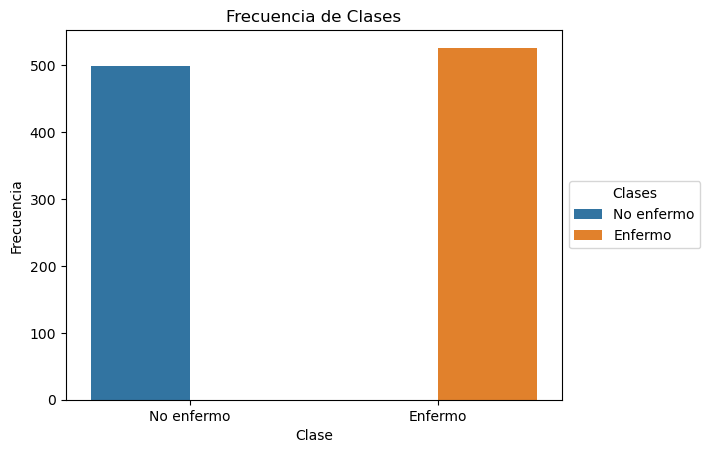

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

Y = dataframe['target']

# Cuenta el número de 0s y 1s en la serie 'Y'
value_counts = Y.value_counts()

# Muestra el número exacto de 0s y 1s
print("No enfermos:", value_counts[0])
print("Enfermo:", value_counts[1])

# Genera la figura de frecuencia de clase
sns.countplot(x='target', data=dataframe, hue='target')

# Etiquetas para los ejes
plt.xlabel('Clase')
plt.ylabel('Frecuencia')

# Título del gráfico
plt.title('Frecuencia de Clases')

# Define las etiquetas para las barras del gráfico
plt.xticks([0, 1], ['No enfermo', 'Enfermo'])

# Coloca la leyenda (labels) al lado derecho
plt.legend(labels=['No enfermo', 'Enfermo'], title="Clases", loc="center left", bbox_to_anchor=(1, 0.5))

# Muestra la figura
plt.show()


- De acuerdo a la gráfica de frecuencias se puede observar que hay una mayor precensia de pacientes enfermos (**526**) que de no enfermos (**499**)

In [8]:
#Ordenar el DataFrame por una variable
dataframeTratamiento=dataframe.sort_values(by=['age'])
dataframeTratamiento.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
60,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
118,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
668,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
64,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
572,34,1,3,118,182,0,0,174,0,0.0,2,0,2,1


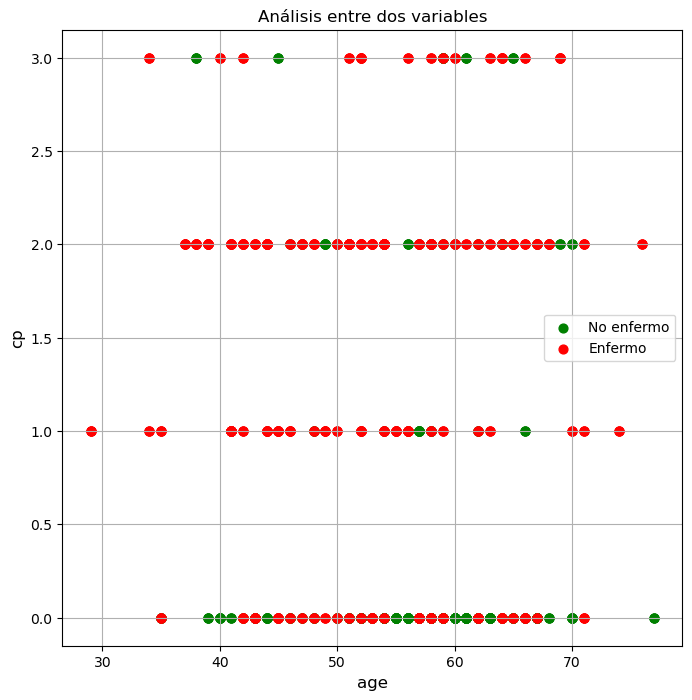

In [9]:
#Visualización 2D: varias variables para análisis
import matplotlib.pyplot as plt
#plt.style.use('classic')
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('age', fontsize = 12)
ax.set_ylabel('cp', fontsize = 12)
ax.set_title('Análisis entre dos variables', fontsize = 12)
targets = [0, 1]# 0 no enfermo. 1 enfermo
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = dataframeTratamiento['target'] == target
    ax.scatter(dataframeTratamiento.loc[indicesToKeep, 'age']
               , dataframeTratamiento.loc[indicesToKeep, 'cp']
               , c = color
               , s = 40)
ax.legend(['No enfermo','Enfermo'])
ax.grid()
plt.show()

- La correlación entre estas dos variables sugeriere  una tendencia o un patrón en la aparición de enfermedades del corazón con respecto a la edad. En este caso se puede determinar que tanto la variable age como cp estan estrachamente correlacionadas en la precensia de enfermedades cardiacas. Lo que significa que las enfermedades del corazón podrían ser más comunes a medida que las personas envejecen.


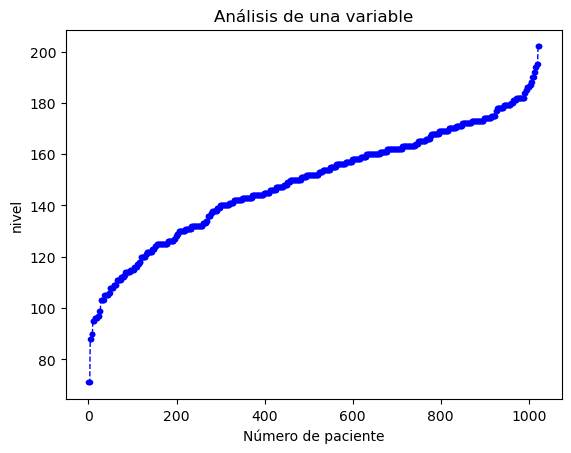

In [10]:
#Visualización 2D: una variable para análisis
#print(plt.style.available)
#plt.style.use('dark_background')
#plt.style.use('seaborn-darkgrid')

dataframeTratamientoOrdenado=dataframeTratamiento.sort_values(by=['thalach'])

variableAnalisis=dataframeTratamientoOrdenado.loc[:,['thalach']]

cantidadMuestras=len(dataframeTratamientoOrdenado.index)
arrayCantidadMuestras= range(cantidadMuestras)

plt.plot(arrayCantidadMuestras,variableAnalisis, color='blue', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='blue', markersize=3)
#plt.ylim((0,35))
plt.title('Análisis de una variable')
plt.xlabel('Número de paciente')
plt.ylabel('nivel')
plt.show()

- El gráfico muestra una correlación positiva entre el número de observaciones y el valor, lo que significa que a medida que aumenta el número de observaciones, también lo hace el valor. Esto podría indicar que a medida que se recogen más datos (más observaciones), el valor de la variable en cuestión tiende a aumentar.

<span style="color:#FF5733; font-size:22px; font-weight:bold">Análisis de variables categóricas</span>

In [11]:
def descripcionCantidadCategorias(dataframe, categorical_features):
    cantidadTotalVariables = len(dataframe.columns) 
    cantidadVariablesCategoricas = len(categorical_features)
    for variable in categorical_features:
        cantidadCategorías=dataframe[variable].nunique()
        print('Cantidad de categorías en la variable',variable,':',cantidadCategorías)
    return cantidadVariablesCategoricas

In [12]:
categorical_features = ['cp',  'slope','sex', 'exang', 'thal','restecg', 'fbs']


In [13]:
cantidadVariablesCategoricas=descripcionCantidadCategorias(dataframe, categorical_features)
print('cantidad de variables categóricas:',cantidadVariablesCategoricas)

Cantidad de categorías en la variable cp : 4
Cantidad de categorías en la variable slope : 3
Cantidad de categorías en la variable sex : 2
Cantidad de categorías en la variable exang : 2
Cantidad de categorías en la variable thal : 4
Cantidad de categorías en la variable restecg : 3
Cantidad de categorías en la variable fbs : 2
cantidad de variables categóricas: 7


- Hay 2 variables categóricas ordinales **cp** y **slope**
- Existen 5 variables categóricas nominales **sex**, **exang**, **thal**, **restecg** y **fbs**

**cp:** tipo de dolor en el pecho

         - Valor 1: angina típica
         - Valor 2: angina atípica
         - Valor 3: dolor no anginoso
         - Valor 4: asintomático
         
**slope:** la pendiente del segmento ST del ejercicio máximo

         - Valor 1: pendiente ascendente
         - Valor 2: plano
         - Valor 3: pendiente descendente
         
**sex:** sexo (1 = masculino; 0 = femenino)

**exang:** angina inducida por el ejercicio (1 = sí; 0 = no)

**thal:** 3 = normal; 6 = defecto fijo; 7 = defecto reversible

**restecg:** resultados electrocardiográficos en reposo
         - Valor 0: normal
         - Valor 1: tener anomalía de la onda ST-T
         - Valor 2: muestra hipertrofia ventricular izquierda probable o definitiva según los criterios de Estes 20 electrocardiogramas
         
**fbs:** (azúcar en sangre en ayunas > 120 mg/dl) (1 = verdadero; 0 = falso)

<span style="color:#FF5733; font-size:22px; font-weight:bold">Análisis de correlación</span>

In [14]:
#Análisis entre dos variables: x, y
x = np.array([5,5,1])
y = np.array([1,2,5])

#Covarianza
covariance = np.cov(x, y, bias=True)[0][1]
#bias: False para (N - 1) si es una muestra, True para (N) si es toda la población
print('Covarianza:',covariance)

#Diccionario
dict = {'X': x,
        'Y': y}
#Creación de dataframe a partir de un diccionario
df = pd.DataFrame(dict)

#Desviación estándar de una variable
std=df['Y'].std(ddof=0)
print('Desviación estándar:',std)

#Correlaciones
df.corr()

Covarianza: -3.111111111111111
Desviación estándar: 1.699673171197595


,X,Y
X,1.000000,-0.970725
Y,-0.970725,1.000000


In [15]:
#Análisis entre tres variables: u1, u2, u3
u1 = np.array([5,1])
u2 = np.array([5,2])
u3 = np.array([1,5])

#Covarianza
covariance = np.cov(u2, u3, bias=True)[0][1]
#bias: False para (N - 1) si es una muestra, True para (N) si es toda la población
print('Covarianza:',covariance)

#Diccionario
dict = {'u1': u1,
        'u2': u2,
        'u3': u3}
 
#Creación de dataframe a partir de un diccionario
df = pd.DataFrame(dict)

#Desviación estándar de una variable
std=df['u3'].std(ddof=0)
print('Desviación estándar:',std)

#Correlaciones
df.corr()

Covarianza: -3.0
Desviación estándar: 2.0


,u1,u2,u3
u1,1.0,1.0,-1.0
u2,1.0,1.0,-1.0
u3,-1.0,-1.0,1.0


In [16]:
#Análisis entre todas las variables
cr=dataframe.corr(numeric_only = True)
cr.head(15)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.103240,-0.071966,0.271121,0.219823,0.121243,-0.132696,-0.390227,0.088163,0.208137,-0.169105,0.271551,0.072297,-0.229324
sex,-0.103240,1.000000,-0.041119,-0.078974,-0.198258,0.027200,-0.055117,-0.049365,0.139157,0.084687,-0.026666,0.111729,0.198424,-0.279501
cp,-0.071966,-0.041119,1.000000,0.038177,-0.081641,0.079294,0.043581,0.306839,-0.401513,-0.174733,0.131633,-0.176206,-0.163341,0.434854
trestbps,0.271121,-0.078974,0.038177,1.000000,0.127977,0.181767,-0.123794,-0.039264,0.061197,0.187434,-0.120445,0.104554,0.059276,-0.138772
chol,0.219823,-0.198258,-0.081641,0.127977,1.000000,0.026917,-0.147410,-0.021772,0.067382,0.064880,-0.014248,0.074259,0.100244,-0.099966
fbs,0.121243,0.027200,0.079294,0.181767,0.026917,1.000000,-0.104051,-0.008866,0.049261,0.010859,-0.061902,0.137156,-0.042177,-0.041164
restecg,-0.132696,-0.055117,0.043581,-0.123794,-0.147410,-0.104051,1.000000,0.048411,-0.065606,-0.050114,0.086086,-0.078072,-0.020504,0.134468
thalach,-0.390227,-0.049365,0.306839,-0.039264,-0.021772,-0.008866,0.048411,1.000000,-0.380281,-0.349796,0.395308,-0.207888,-0.098068,0.422895
exang,0.088163,0.139157,-0.401513,0.061197,0.067382,0.049261,-0.065606,-0.380281,1.000000,0.310844,-0.267335,0.107849,0.197201,-0.438029
oldpeak,0.208137,0.084687,-0.174733,0.187434,0.064880,0.010859,-0.050114,-0.349796,0.310844,1.000000,-0.575189,0.221816,0.202672,-0.438441


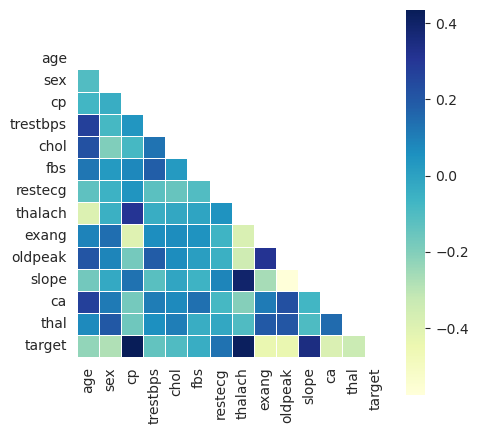

In [17]:
#Un mapa de calor personalizado: colores, región inferior a la diagonal, tamaño
mask = np.zeros_like(cr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(5, 5))
    ax = sns.heatmap(cr, mask=mask, square=True, linewidths=.5, cmap="YlGnBu")
plt.savefig('attribute_correlations.png')

In [18]:
#Análisis a partir de los valores: correlaciones positivas
dfCorrOrdenado=cr.sort_values(by=['target'], ascending=False)
dfCorrOrdenado['target'].head(10)

target      1.000000
cp          0.434854
thalach     0.422895
slope       0.345512
restecg     0.134468
fbs        -0.041164
chol       -0.099966
trestbps   -0.138772
age        -0.229324
sex        -0.279501
Name: target, dtype: float64

Las 3 variables más correlacionadas positivamente son: **cp**( 0.434854), **thalach** (0.422895), **slope** (0.345512)

In [19]:
#Análisis a partir de los valores: correlaciones negativas
dfCorrOrdenado=cr.sort_values(by=['target'], ascending=True)
dfCorrOrdenado['target'].head(10)

oldpeak    -0.438441
exang      -0.438029
ca         -0.382085
thal       -0.337838
sex        -0.279501
age        -0.229324
trestbps   -0.138772
chol       -0.099966
fbs        -0.041164
restecg     0.134468
Name: target, dtype: float64

Las 3 variables más correlacionadas negativamente son: **oldpeak**(-0.438441), **exang** (-0.438029), **ca** (-0.382085)

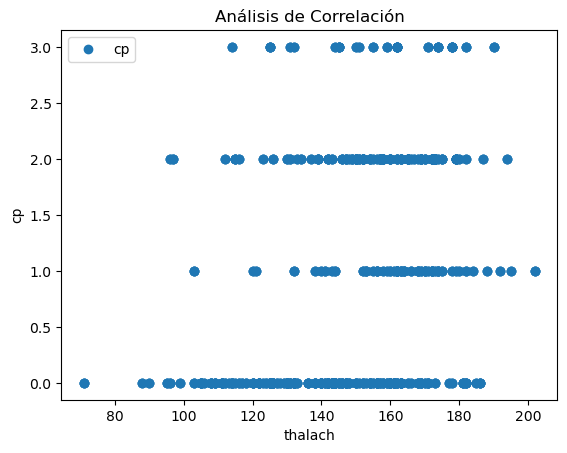

In [20]:
#Visualización para análisis entre dos variables
variable1Analisis='thalach'
variable2Analisis='cp'
dataframe.plot(x=variable1Analisis, y=variable2Analisis, style='o')  
plt.title('Análisis de Correlación')  
plt.xlabel(variable1Analisis)  
plt.ylabel(variable2Analisis)  
plt.show() 

- En la gráfica podemos ver una disperción bastante ordenada, puesto que estan las dos variables más correlacionadas positivamente, en donde los dolores en el pecho se establecen en sus 4 niveles y el ritmo cardiaco máximo alcanzdo irá variando de acuerdo a los dolores en el pecho.

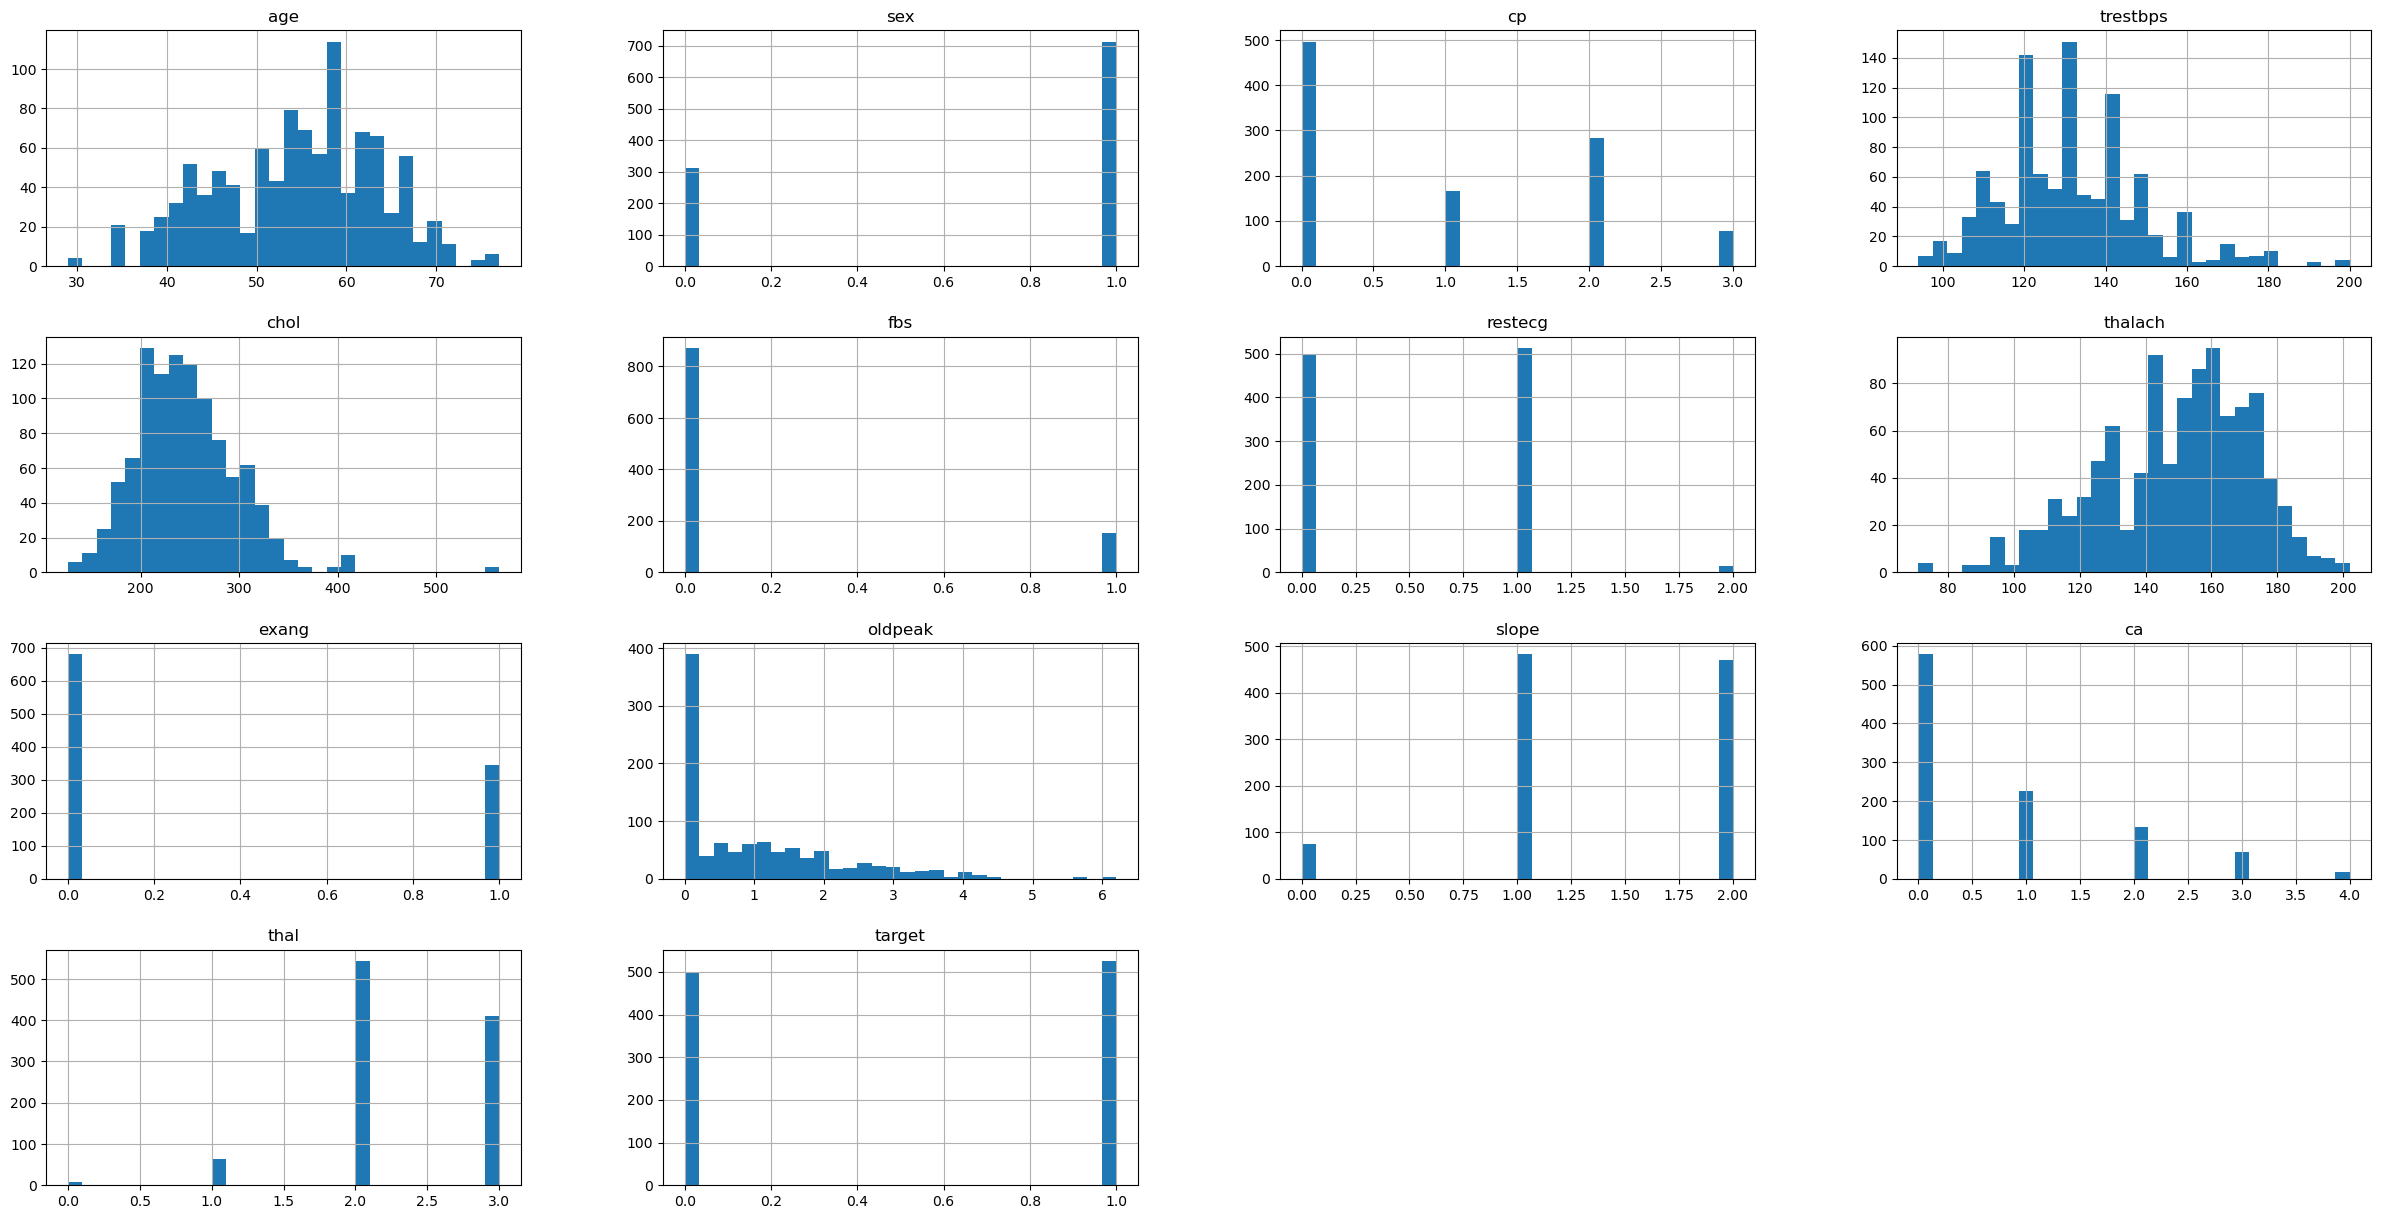

In [21]:
dataframe.hist(bins=30, figsize=(30, 15))

# A continuación, guarda la imagen en un archivo con un nombre específico y formato (por ejemplo, PNG).
plt.savefig('histograma.png')

# Finalmente, muestra la imagen en la pantalla (opcional).
plt.show()

<span style="color:#FF5733; font-size:22px; font-weight:bold">Selección y extracción de variables</span>

In [22]:
#Selección de variables según el análisis de correlación
dataframe=dataframe[['cp', 'thalach', 'slope', 'oldpeak', 'exang','ca','target']]
print(dataframe.shape)
dataframe.head(10)

(1025, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
0,0,168,2,1.0,0,2,0
1,0,155,0,3.1,1,0,0
2,0,125,0,2.6,1,0,0
3,0,161,2,0.0,0,1,0
4,0,106,1,1.9,0,3,0
5,0,122,1,1.0,0,0,1
6,0,140,0,4.4,0,3,0
7,0,145,1,0.8,1,1,0
8,0,144,2,0.8,0,0,0
9,0,116,1,3.2,1,2,0


<span style="color:#FF5733; font-size:22px; font-weight:bold">Análisis y eliminación de outliers</span>

In [23]:
from sklearn import preprocessing
data_scaled_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_scaled_minmax = data_scaled_minmax.fit_transform(dataframe)
dataframe_scaled_minmax = pd.DataFrame(data=data_scaled_minmax,columns=dataframe.columns)
print(dataframe_scaled_minmax.shape)
dataframe_scaled_minmax.head(10)

(1025, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
0,0.0,0.740458,1.0,0.161290,0.0,0.50,0.0
1,0.0,0.641221,0.0,0.500000,1.0,0.00,0.0
2,0.0,0.412214,0.0,0.419355,1.0,0.00,0.0
3,0.0,0.687023,1.0,0.000000,0.0,0.25,0.0
4,0.0,0.267176,0.5,0.306452,0.0,0.75,0.0
5,0.0,0.389313,0.5,0.161290,0.0,0.00,1.0
6,0.0,0.526718,0.0,0.709677,0.0,0.75,0.0
7,0.0,0.564885,0.5,0.129032,1.0,0.25,0.0
8,0.0,0.557252,1.0,0.129032,0.0,0.00,0.0
9,0.0,0.343511,0.5,0.516129,1.0,0.50,0.0


In [26]:
import plotly.graph_objs as go
import numpy as np
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

# Genera datos de ejemplo (reemplaza esto con tus propios datos)
#np.random.seed(0)
#data = np.random.rand(100, 3)
#np.random.rand(200)

# Selecciona las tres columnas que deseas convertir
columnas_seleccionadas = dataframe_scaled_minmax[['cp', 'thalach', 'slope']]

# Convierte las columnas seleccionadas en un numpy.ndarray
data = columnas_seleccionadas.to_numpy()

# Define un umbral (de distancia euclidiana) para identificar outliers (puedes ajustar esto según tus necesidades)
umbral = 1.2

# Calcula la distancia euclidiana desde el origen (centro) para cada punto de datos
distancias = np.linalg.norm(data, axis=1)

# Identifica los índices de los outliers
outliers_indices = np.where(distancias > umbral)[0]

# Separa los datos en dos grupos: puntos normales y outliers
puntos_normales = data[distancias <= umbral]
outliers = data[outliers_indices]

# Crea una figura 3D interactiva
fig = go.Figure()

# Plotea los puntos de datos normales (dentro de la esfera)
fig.add_trace(go.Scatter3d(
    x=puntos_normales[:, 0],
    y=puntos_normales[:, 1],
    z=puntos_normales[:, 2],
    mode='markers',
    marker={'color':'blue', 'size':4},
    name='Puntos Normales'
))

# Plotea los outliers (fuera de la esfera)
fig.add_trace(go.Scatter3d(
    x=outliers[:, 0],
    y=outliers[:, 1],
    z=outliers[:, 2],
    mode='markers',
    marker={'color':'red', 'size':4},
    name='Outliers'
))

# Crea una esfera que excluye los outliers
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = umbral * np.outer(np.cos(u), np.sin(v))
y = umbral * np.outer(np.sin(u), np.sin(v))
z = umbral * np.outer(np.ones_like(u), np.cos(v))

fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='greens', opacity=0.3, showscale=False, name='Esfera Umbral'))

# Configura el diseño de la figura
fig.update_layout(
    scene={
        'xaxis_title':'X: cp', #EJE X
        'yaxis_title':'Y: thalach', #EJE Y
        'zaxis_title':'Z: slope' #EJE Z
    },
    scene_camera={
        'center':{'x':0, 'y':0, 'z':0},
        'eye':{'x':1.25, 'y':1.25, 'z':1.25}
    }
)

# Muestra la figura interactiva
fig.show()

# Calcular la distancia al origen para cada muestra
dataframe_scaled_minmax['DIST'] = np.sqrt(dataframe_scaled_minmax['cp']**2 + dataframe_scaled_minmax['thalach']**2 + dataframe_scaled_minmax['slope']**2)
# Filtrar el DataFrame para obtener solo las muestras dentro de la esfera
df_filtrado = dataframe_scaled_minmax[dataframe_scaled_minmax['DIST'] <= umbral]
print(df_filtrado.shape)
df_filtrado.head(20)

(592, 8)


,cp,thalach,slope,oldpeak,exang,ca,target,DIST
1,0.000000,0.641221,0.0,0.500000,1.0,0.00,0.0,0.641221
2,0.000000,0.412214,0.0,0.419355,1.0,0.00,0.0,0.412214
4,0.000000,0.267176,0.5,0.306452,0.0,0.75,0.0,0.566906
5,0.000000,0.389313,0.5,0.161290,0.0,0.00,1.0,0.633691
6,0.000000,0.526718,0.0,0.709677,0.0,0.75,0.0,0.526718
7,0.000000,0.564885,0.5,0.129032,1.0,0.25,0.0,0.754384
8,0.000000,0.557252,1.0,0.129032,0.0,0.00,0.0,1.144784
9,0.000000,0.343511,0.5,0.516129,1.0,0.50,0.0,0.606630
10,0.000000,0.412214,0.5,0.258065,0.0,0.00,1.0,0.648012
11,0.000000,0.496183,0.5,0.483871,1.0,0.00,0.0,0.704413


<span style="color:#FF5733; font-size:22px; font-weight:bold">Segmentación de Datos: </span>

In [25]:
# Calcular la distancia al origen para cada muestra
dataframe_scaled_minmax['DIST'] = np.sqrt(dataframe_scaled_minmax['cp']**2 + dataframe_scaled_minmax['thalach']**2 + dataframe_scaled_minmax['slope']**2)
# Filtrar el DataFrame para obtener solo las muestras dentro de la esfera
df_filtrado = dataframe_scaled_minmax[dataframe_scaled_minmax['DIST'] <= umbral]
df_filtrado = df_filtrado.drop(['DIST'], axis=1)
#Guardar el dataset
df_filtrado.to_csv("DatasetNormalizadoyFiltrado.csv", sep=";",index = False)
print(df_filtrado.shape)
df_filtrado.head(20)

(592, 7)


,cp,thalach,slope,oldpeak,exang,ca,target
1,0.000000,0.641221,0.0,0.500000,1.0,0.00,0.0
2,0.000000,0.412214,0.0,0.419355,1.0,0.00,0.0
4,0.000000,0.267176,0.5,0.306452,0.0,0.75,0.0
5,0.000000,0.389313,0.5,0.161290,0.0,0.00,1.0
6,0.000000,0.526718,0.0,0.709677,0.0,0.75,0.0
7,0.000000,0.564885,0.5,0.129032,1.0,0.25,0.0
8,0.000000,0.557252,1.0,0.129032,0.0,0.00,0.0
9,0.000000,0.343511,0.5,0.516129,1.0,0.50,0.0
10,0.000000,0.412214,0.5,0.258065,0.0,0.00,1.0
11,0.000000,0.496183,0.5,0.483871,1.0,0.00,0.0


<span style="color:#FF5733; font-size:22px; font-weight:bold">Conclusiones</span>


En base al análisis exploratorio realizado en el dataset Heart Disease, se pudo determinar:
- La edad mínima es de 29, la media de la edad es 54.434146 y la edad máxima es de 77. En cuanto a la cantidad mínima de colesteról es de 126.00000 y la cantidad máxima de colesteról es de 564.00000
- De acuerdo a la gráfica de frecuencias se puede observar que hay una mayor precensia de pacientes enfermos (526) que de no enfermos (499)
- Hay una mayor concentración de colesterol entre los pacientes de 50 a 70 años, ya que tienen niveles de colesterol entre los 200 y 300. Sin embargo no se puede determinar una correlación tan centrada.
- A medida que se han registrado más pacientes se puede observar que la presión arterial en reposo de cada uno varia demasiado con una tendencia a incrementarse cada vez más.
- Las 3 variables más correlacionadas positivamente son: **cp**( 0.434854), **thalach** (0.422895), **slope** (0.345512)
- Las 3 variables más correlacionadas positivamente son: **oldpeak**(-0.438441), **exang** (-0.438029), **ca** (-0.382085)

<span style="color:#FF5733; font-size:22px; font-weight:bold">Referencias</span>

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.<br>
- Hurtado Ortiz, R. (2023, October 6). Preparación de datos: análisis exploratorio. GensciNet. https://genscinet.com/analisis-exploratorio/
